In [2]:
import numpy as np
import os
import soundfile as sf
import pandas as pd
from proto import mfcc, mspec
from proto2 import concatHMMs, log_multivariate_normal_density_diag, viterbi
from prondict import prondict
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers, models, utils, losses, optimizers
import matplotlib.pyplot as plt


In [3]:
#lab3_proto.py

def words2phones(wordList, pronDict, addSilence=True, addShortPause=True):
    """ word2phones: converts word level to phone level transcription adding silence

    Args:
       wordList: list of word symbols
       pronDict: pronunciation dictionary. The keys correspond to words in wordList
       addSilence: if True, add initial and final silence
       addShortPause: if True, add short pause model "sp" at end of each word
    Output:
       list of phone symbols
    """
    phone_list = []
    if addSilence:
        phone_list.append('sil')
    for symbol in wordList:
        for item in pronDict[symbol]:
            phone_list.append(item)
        phone_list.append('sp')
    if addSilence:
        phone_list.append('sil')
    return list(phone_list)

def forcedAlignment(lmfcc, phoneHMMs, phoneTrans):
    """ forcedAlignmen: aligns a phonetic transcription at the state level

    Args:
       lmfcc: NxD array of MFCC feature vectors (N vectors of dimension D)
              computed the same way as for the training of phoneHMMs
       phoneHMMs: set of phonetic Gaussian HMM models
       phoneTrans: list of phonetic symbols to be aligned including initial and
                   final silence

    Returns:
       list of strings in the form phoneme_index specifying, for each time step
       the state from phoneHMMs corresponding to the viterbi path.
    """

def hmmLoop(hmmmodels, namelist=None):
    """ Combines HMM models in a loop

    Args:
       hmmmodels: list of dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to combine, if None,
                 all the models in hmmmodels are used

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models
       stateMap: map between states in combinedhmm and states in the
                 input models.

    Examples:
       phoneLoop = hmmLoop(phoneHMMs)
       wordLoop = hmmLoop(wordHMMs, ['o', 'z', '1', '2', '3'])
    """


In [4]:
#lab3_tools.py
def path2info(path):
    """
    path2info: parses paths in the TIDIGIT format and extracts information
               about the speaker and the utterance

    Example:
    path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')
    """
    rest, filename = os.path.split(path)
    rest, speakerID = os.path.split(rest)
    rest, gender = os.path.split(rest)
    digits = filename[:-5]
    repetition = filename[-5]
    return gender, speakerID, digits, repetition

def loadAudio(filename):
    """
    loadAudio: loads audio data from file using pysndfile

    Note that, by default pysndfile converts the samples into floating point
    numbers and rescales them in the range [-1, 1]. This is avoided by specifying
    the option dtype=np.int16 which keeps both the original data type and range
    of values.
    """
    return sf.read(filename, dtype='int16')

def frames2trans(sequence, outfilename=None, timestep=0.01):
    """
    Outputs a standard transcription given a frame-by-frame
    list of strings.

    Example (using functions from Lab 1 and Lab 2):
    phones = ['sil', 'sil', 'sil', 'ow', 'ow', 'ow', 'ow', 'ow', 'sil', 'sil']
    trans = frames2trans(phones, 'oa.lab')

    Then you can use, for example wavesurfer to open the wav file and the transcription
    """
    sym = sequence[0]
    start = 0
    end = 0
    trans = ''
    for t in range(len(sequence)):
        if sequence[t] != sym:
            trans = trans + str(start) + ' ' + str(end) + ' ' + sym + '\n'
            sym = sequence[t]
            start = end
        end = end + timestep
    trans = trans + str(start) + ' ' + str(end) + ' ' + sym + '\n'
    if outfilename != None:
        with open(outfilename, 'w') as f:
            f.write(trans)
    return trans

In [5]:
print(path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav'))
print(loadAudio('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav'))

phoneHMMs = np.load('lab2_models_all.npz', allow_pickle = True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(len(stateList))

('man', 'ae', 'z9z6531', 'a')
(array([11, 13, 11, ...,  9,  9,  9], dtype=int16), 20000)
61


In [6]:
#using python file i/o
# f = open('phoneHmms_states.txt', 'w')
# for state in stateList:
#     f.write(state)
# f.close()

#using pandas df
df = pd.DataFrame(stateList)
df.to_csv('phoneHmms_states.csv', header=False, index=False) 

In [7]:
#For 1 File - 4.1 - 4.2
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
wordTrans = list(path2info(filename)[2])
print(wordTrans)
phoneTrans = words2phones(wordTrans, prondict)
print(phoneTrans)
print()
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
#print(utteranceHMM)

stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
print(stateTrans)
print()


viterbi_loglik, viterbi_states = viterbi(log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'],
                      utteranceHMM['covars']), np.log(utteranceHMM['startprob']),
                      np.log(utteranceHMM['transmat']), True)

state_list = pd.read_csv('phoneHmms_states.csv', header = None)
state_list = state_list[0].to_list()
print(len(state_list))

viterbiStateTrans = [stateTrans[state] for state in viterbi_states]
print(viterbiStateTrans)

targets = [state_list.index(state) for state in viterbiStateTrans]
print(targets)


trans = frames2trans(viterbiStateTrans, outfilename='z43a.lab') #wavesurfer not working on my machine..need to verify this part!
print(trans)



    

['z', '4', '3']
['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']

['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sp_0', 'sil_0', 'sil_1', 'sil_2']

61
['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 

In [8]:
#For all files - 4.3
def feature_extraction(samples):
    lmfcc = mfcc(samples)
    mspec_all = mspec(samples)
    return lmfcc, mspec_all

def forced_alignment(filename, phone_HMMs, pron_dict):
    wordTrans = list(path2info(filename)[2])
    phoneTrans = words2phones(wordTrans, pron_dict)
    utteranceHMM = concatHMMs(phone_HMMs, phoneTrans)
    stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
    return utteranceHMM, stateTrans

def create_train_data(train_fpath, phone_HMMs, pron_dict, state_list):
    traindata = []
    for root, dirs, files in os.walk(train_fpath):
        for file in files:
            if file.endswith('.wav'):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                lmfcc, mspec_all = feature_extraction(samples)
                utteranceHMM, stateTrans = forced_alignment(filename, phone_HMMs, pron_dict)
                _, viterbi_states = viterbi(log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'],
                          utteranceHMM['covars']), np.log(utteranceHMM['startprob']),
                          np.log(utteranceHMM['transmat']), True)
                viterbiStateTrans = [stateTrans[state] for state in viterbi_states]
                targets = [state_list.index(state) for state in viterbiStateTrans]
                traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspec_all, 'targets': targets})
    return traindata
                
def create_test_data(test_path, phone_HMMs, pron_dict, state_list):
    testdata = []
    for root, dirs, files in os.walk(test_path):
        for file in files:
            if file.endswith('.wav'):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                lmfcc, mspec_all = feature_extraction(samples)
                utteranceHMM, stateTrans = forced_alignment(filename, phone_HMMs, pron_dict)
                _, viterbi_states = viterbi(log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'],
                          utteranceHMM['covars']), np.log(utteranceHMM['startprob']),
                          np.log(utteranceHMM['transmat']), True)
                viterbiStateTrans = [stateTrans[state] for state in viterbi_states]
                targets = [state_list.index(state) for state in viterbiStateTrans]
                testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspec_all, 'targets': targets})
    return testdata

def split_data(train_fpath):    
    traindata = np.load(train_fpath, allow_pickle=True)

    samples = len(traindata)
    val_size = int(0.1 * samples)
    print(val_size)
    val_n_speakers = int(val_size / 77) #Why 77? 77 is the number of smaples per speaker on the dataset

    if val_n_speakers % 2 != 0:
        val_n_speakers += 1

    val_size = val_n_speakers * 77
    print(val_size)
    samples_gender = int(val_size / 2)

    valdata = [traindata[i] for i in range(0, samples_gender)]
    valdata.extend([traindata[i] for i in range(4235, 4235 + samples_gender)])
    trainingdata = [sample for sample in traindata if sample['filename'] not in [x['filename'] for x in valdata]]

    np.save('data/trainingdata.npy', trainingdata)
    np.save('data/valdata.npy', valdata)
    return

def dynamic_features(data_fpath, input_type, dynamic=True):
    data = np.load(data_fpath, allow_pickle=True)
    s = data_fpath.split('/')
    if dynamic:
        for sample in data:
            dfeature_list = []
            i_max = len(sample[input_type]) - 1
            for i, feature in enumerate(sample[input_type]):
                dfeature = np.zeros((7, feature.shape[0]))

                dfeature[0] = sample[input_type][np.abs(i - 3)]
                dfeature[1] = sample[input_type][np.abs(i - 2)]
                dfeature[2] = sample[input_type][np.abs(i - 1)]
                dfeature[3] = sample[input_type][i]
                dfeature[4] = sample[input_type][i_max - np.abs(i_max - (i + 1))]
                dfeature[5] = sample[input_type][i_max - np.abs(i_max - (i + 2))]
                dfeature[6] = sample[input_type][i_max - np.abs(i_max - (i + 3))]
                dfeature_list.append(dfeature)
            sample['features'] = np.array(dfeature_list)
        np.save('data/' + input_type + '/dynamic/' + s[-1], data)
    else:
        for sample in data:
            feature_list = [np.array(feature) for feature in sample[input_type]]
            sample['features'] = np.array(feature_list)
        np.save('data/' + input_type + '/nondynamic/' + s[-1], data)
    return

def non_dynamic_features(data_fpath, input_type):
    data = np.load(data_fpath, allow_pickle=True)
    for sample in data:
        feature_list = [np.array(feature) for feature in sample[input_type]]
        sample['features'] = np.array(feature_list)
    
    s = data_fpath.split('/')
    np.save('data/' + input_type + '/nondynamic/' + s[-1], data)
    return


def feature_std(dtrainfpath, dvalfpath, dtestfpath, input_type, feature_type):
    paths = [dtrainfpath, dvalfpath, dtestfpath]
    Xs = []
    ys = []
    for p in paths:
        ddata = np.load(p, allow_pickle=True)

        N = 0
        D = np.prod(np.array(ddata[0]['features']).shape[1:3])
        for sample in ddata:
            N += sample['features'].shape[0]

        X = np.zeros((N, D))
        y = np.zeros((N, 1))
        prev_idx = 0
        for sample in ddata:
            dynamic_features = np.array(sample['features'])
            n = dynamic_features.shape[0]
            X[prev_idx:prev_idx + n] = dynamic_features.reshape((n, D))
            y[prev_idx:prev_idx + n, 0] = sample['targets']
            prev_idx += n
        Xs.append(X)
        ys.append(y)

    scaler = preprocessing.StandardScaler().fit(Xs[0])
    sets = ['train', 'val', 'test']
    for i, s in enumerate(sets):
        Xs[i] = scaler.transform(Xs[i])
        Xs[i] = Xs[i].astype('float32')
        print(Xs[i].shape)
        np.save('data/' + input_type + '/' + feature_type + '/X_' + s + '.npy', Xs[i])
        np.save('data/' + input_type + '/' + feature_type + '/y_' + s + '.npy', ys[i])
    return    


In [8]:
input_type = ['lmfcc', 'mspec']
dynamic = [False, True]
feature_type = ['nondynamic', 'dynamic']

#train_path = 'tidigits/disc_4.1.1/tidigits/train'
#traindata = create_train_data(train_path, phoneHMMs, prondict, state_list)
#
#test_path = 'tidigits/disc_4.2.1/tidigits/test'
#testdata = create_test_data(test_path, phoneHMMs, prondict, state_list)
#
#np.save('data/traindata.npy', traindata)
#np.save('data/testdata.npy', testdata)

#split_data('data/traindata.npy')
#for j in range(2):
#    typ = input_type[j]
#    for i in range(2):
#        dy = dynamic[i]
#        dynamic_features('data/trainingdata.npy', typ, dy)
#        print('1')
#        dynamic_features('data/valdata.npy', typ, dy)
#        print('2')
#        dynamic_features('data/testdata.npy', typ, dy)
#        print('3')
#print('4')
#for j in range(2):
#    typ = input_type[j]
#    for i in range(2):
#        feat = feature_type[i]
#        path = 'data/' + typ + '/' + feat + '/'
#        feature_std(path + 'trainingdata.npy', path + 'valdata.npy', path + 'testdata.npy', typ, feat)
#        print(path)

4 Layers
Train on 1349718 samples, validate on 157674 samples
Epoch 1/20
1349718/1349718 [==============================] - 26s 19us/sample - loss: 0.7653 - accuracy: 0.7489 - val_loss: 0.7235 - val_accuracy: 0.7632
Epoch 2/20
1349718/1349718 [==============================] - 26s 19us/sample - loss: 0.6029 - accuracy: 0.7954 - val_loss: 0.6849 - val_accuracy: 0.7759
Epoch 3/20
1349718/1349718 [==============================] - 25s 19us/sample - loss: 0.5549 - accuracy: 0.8093 - val_loss: 0.6812 - val_accuracy: 0.7778
Epoch 4/20
1349718/1349718 [==============================] - 26s 19us/sample - loss: 0.5264 - accuracy: 0.8183 - val_loss: 0.6868 - val_accuracy: 0.7798
Epoch 5/20
1348864/1349718 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.8241
Epoch 00005: saving model to checkpoints/
1349718/1349718 [==============================] - 26s 19us/sample - loss: 0.5065 - accuracy: 0.8241 - val_loss: 0.6769 - val_accuracy: 0.7857
Epoch 6/20
1349718/1349718 [=====

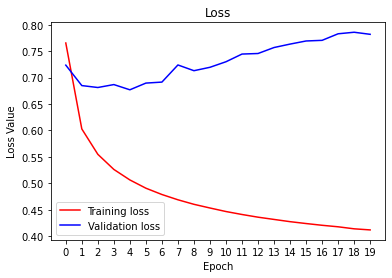

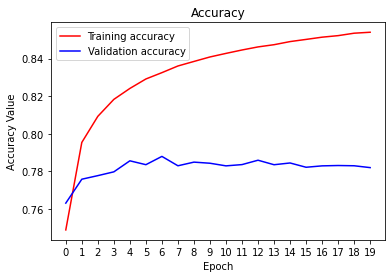

In [15]:
#DNN model
nlayers = 4

input_type = ['lmfcc', 'mspec']
dynamic = [False, True]
feature_type = ['nondynamic', 'dynamic']

feature_type = ['dynamic', 'nondynamic']


for j in range(1):
    typ = input_type[j]
    for i in range(1):
        feat = feature_type[i]
        dpath = 'data/' + typ + '/' + feat + '/'
        rpath = 'results/' + typ + '/' + feat + '/'

        #Make lables one hot

        X_train = np.load(dpath + 'X_train.npy', allow_pickle=True)
        X_val = np.load(dpath + 'X_val.npy', allow_pickle=True)

        y_train = np.load(dpath + 'y_train.npy', allow_pickle=True)
        y_val = np.load(dpath + 'y_val.npy', allow_pickle=True)

        Y_train = tf.keras.utils.to_categorical(y_train)
        Y_val = tf.keras.utils.to_categorical(y_val)

        for k in range(3, nlayers):
            print(str(k + 1) + " Layers")
            output_classes = 61 #Number of states in state list
            f_count = X_train.shape[1]

            checkpoint_path = "checkpoints/"
            checkpoint_dir = os.path.dirname(checkpoint_path)

            # Create a callback that saves the model's weights
            cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                            save_weights_only=True,
                                                            verbose=1, period=5)

            model = models.Sequential()
            model.add(layers.Dense(256, input_shape=(f_count,), activation = 'relu'))
            for l in range(k):
                model.add(layers.Dense(256, activation='relu'))
            model.add(layers.Dense(output_classes, activation = 'softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            #Model training
            ep = 20
            model_history = model.fit(X_train, Y_train, epochs=ep, validation_data = (X_val, Y_val), batch_size = 256, callbacks=[cp_callback])

            #Training and Validation loss plot
            training_loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']

            plt.figure()
            plt.plot(training_loss, 'r', label='Training loss')
            plt.plot(val_loss, 'b', label='Validation loss')
            plt.title('Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss Value')
            #plt.ylim([0, 1])
            plt.xticks(np.arange(0, ep, 1))
            plt.legend()
            #plt.savefig(rpath + 'loss_' + str(k + 1) + 'l')
            plt.show()

            #Training and Validation accuracy plot

            training_acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            plt.figure()
            plt.plot(training_acc, 'r', label='Training accuracy')
            plt.plot(val_acc, 'b', label='Validation accuracy')
            plt.title('Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy Value')
            #plt.ylim([0, 1])
            plt.xticks(np.arange(0, ep, 1))
            plt.legend()
            #plt.savefig(rpath + 'accuracy_' + str(k + 1) + 'l')
            plt.show()


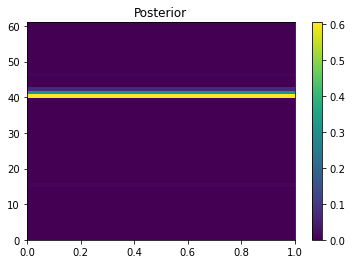

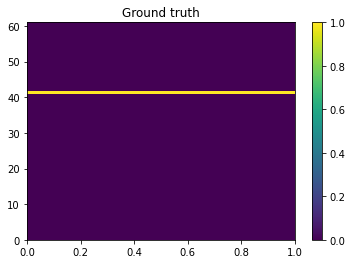

Model accuracy - frame by frame - state level: 0.7677205317043589


In [21]:
dpath = 'data/' + 'lmfcc' + '/' + 'dynamic' + '/'

X_test = np.load(dpath + 'X_test.npy', allow_pickle=True)
y_test = np.load(dpath + 'y_test.npy', allow_pickle=True)
X_train = np.load(dpath + 'X_train.npy', allow_pickle=True)

output_classes = 61 
f_count = X_train.shape[1]
model = models.Sequential()
model.add(layers.Dense(256, input_shape=(f_count,), activation = 'relu'))
for l in range(3):
    model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(output_classes, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint_path = "checkpoints/"
model.load_weights(checkpoint_path)


Y_test = tf.keras.utils.to_categorical(y_test)
X = X_test[i:i+1]
Y = Y_test[i:i+1]

predictions = model.predict(X)

plt.title("Posterior")
plt.pcolormesh(predictions.T)
plt.colorbar()
plt.show()

plt.title("Ground truth")
plt.pcolormesh(Y_test[i:i+1].T)
plt.colorbar()
plt.show()

predictions = model.predict(X_test)

ground_truths = np.argmax(Y_test, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Accuracy frame by frame at thestate level\n" + str(accuracy))
